# Условия

Значения всех параметров (матрицы вероятностей, размерности и т.п.) должны определяться один раз, после чего для вычислений уже используются переменные. "Хардкодить"числа внутри кода не допускается.
- Для заданных матриц переходных вероятностей $M$ и эмиссионных вероятностей $E$ сгенерировать последовательность $\sigma$ скрытых состояний и последовательность $\varepsilon$ наблюдений длины $L$. В качестве начального распределения использовать стационарное распределение матрицы $M$ (собственный вектор, соответсвтующий единичному собственному значению).
- Реализовать алгоритм Витерби: для данных $M, E$ и $\varepsilon$ найти

$$
\sigma_v=\operatorname{argmax}_{\sigma^{\prime}} P\left(\sigma^{\prime}, \varepsilon \mid M, E\right)
$$


Визуализировать результат: построить на графике $\sigma$ и $\sigma_v$ (на оси $x$ позиция, на оси $y$ - номер состояния).
- Реализовать алгоритмы прямого и обратного хода (особое внимание уделите инициализации алгоритмов!). Вычислить $P(\varepsilon)$ с помощью обоих алгоритмов.
- Реализовать апостериорное декодирование.

Визуализировать результат: построить график $P($ state $0 \mid \varepsilon)(l)$.
- Реализовать алгоритм Баума-Велша.

Протестировать алгоритмы для $L=100,500,1000$. Добавить защиту от потери точности через logsumexp и/или нормализацию (см. учебник Durbin et al).

## Разбалловка

* Генератор (первый пункт) и алгоритм Витерби без защиты от потери точности: 4 балла.

* Прямой и обратный ход + апостериорное декодирование (без защиты от потери точности): +3 балла (итого 7).

* Защита от потери точности Витерби: +1 балл

* Защита от потери точности прямого, обратного алгоритмов и апостериорного декодирования: +1 балл

* Алгоритм Баума-Велша - на десятку.

При защите работы могу спрашивать любые дополнительные вопросы по выполненной работе, включая определения вероятностного пространства, независимости событий, условной вероятности, а также просить пояснить, что делают куски кода, используемые функции и методы из numpy и т.п.

Отдельно обращая ваше внимание на условие использовать стационарное распределение (тоже нужно знать, что это) в качестве начального.

Защиту от потери точности проще выполнять через вычисления в log. Тогда суммирование выполняется при помощи функции logsumexp (на Википедии нормально описано, можно пользоваться) - общий приём, который может быть полезен в других задачах. Можно делать через нормализацию столбца на каждом шаге алгоритма (описано в книге), это существенно быстрее, но по опыту проще запутаться и больше времени требуется на отладку.

# Код

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

In [6]:
n_states = 2
n_observations = 6

M = np.array([[0.95, 0.05],
              [0.10, 0.90]])

E = np.array([[1/6]*6,
              [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]])

In [7]:
def stationary_distribution(M):
    eigvals, eigvecs = np.linalg.eig(M.T)
    idx = np.argmin(np.abs(eigvals - 1))
    stat = np.real(eigvecs[:, idx])
    stat = stat / stat.sum()
    stat = np.abs(stat)
    stat = stat / stat.sum()
    return stat

pi = stationary_distribution(M)

## Витерби

In [8]:
def viterbi(observations, M, E, pi):
    L = len(observations)
    log_dp = np.full((L, n_states), -np.inf)
    backpointer = np.zeros((L, n_states), dtype=int)
    log_pi = np.log(pi)
    log_E = np.log(E)
    log_M = np.log(M)

    # Initialization
    log_dp[0] = log_pi + log_E[:, observations[0]]

    # Recursion
    for t in range(1, L):
        for j in range(n_states):
            candidate = log_dp[t-1] + log_M[:, j]
            backpointer[t, j] = np.argmax(candidate)
            log_dp[t, j] = candidate[backpointer[t, j]] + log_E[j, observations[t]]

    # Backtracking
    sigma_v = np.empty(L, dtype=int)
    sigma_v[-1] = np.argmax(log_dp[-1])
    for t in range(L-2, -1, -1):
        sigma_v[t] = backpointer[t+1, sigma_v[t+1]]
    return sigma_v

## Forward & Backward

In [9]:
def forward(observations, M, E, pi):
    L = len(observations)
    alpha = np.zeros((L, n_states))
    scale = np.zeros(L)

    # Initialization
    alpha[0] = pi * E[:, observations[0]]
    scale[0] = alpha[0].sum()
    alpha[0] /= scale[0]

    # Recursion
    for t in range(1, L):
        alpha[t] = (alpha[t-1] @ M) * E[:, observations[t]]
        scale[t] = alpha[t].sum()
        alpha[t] /= scale[t]

    log_prob = np.sum(np.log(scale))
    return alpha, log_prob, scale

In [10]:
def backward(observations, M, E, scale):
    L = len(observations)
    beta = np.zeros((L, n_states))
    beta[-1] = 1/scale[-1]
    for t in range(L-2, -1, -1):
        beta[t] = (M * E[:, observations[t+1]]).dot(beta[t+1])
        beta[t] /= scale[t]
    return beta

In [11]:
# gamma = P(state | observations)
def posterior_decoding(alpha, beta):
    gamma = alpha * beta
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

## Баум Велш

In [12]:
def baum_welch(observations, n_iter=100):
    L = len(observations)
    # Random initialization
    A = np.random.dirichlet(np.ones(n_states), size=n_states)
    B = np.random.dirichlet(np.ones(n_observations), size=n_states)
    pi_est = np.random.dirichlet(np.ones(n_states))

    for iteration in range(n_iter):
        # Forward + scaling
        alpha = np.zeros((L, n_states))
        scale = np.zeros(L)
        alpha[0] = pi_est * B[:, observations[0]]
        scale[0] = alpha[0].sum()
        alpha[0] /= scale[0]
        for t in range(1, L):
            alpha[t] = (alpha[t-1] @ A) * B[:, observations[t]]
            scale[t] = alpha[t].sum()
            alpha[t] /= scale[t]

        # Backward + scaling
        beta = np.zeros((L, n_states))
        beta[-1] = 1/scale[-1]
        for t in range(L-2, -1, -1):
            beta[t] = (A * B[:, observations[t+1]]).dot(beta[t+1])
            beta[t] /= scale[t]

        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)

        # Probability of being in state i at time t and j at t+1
        xi = np.zeros((L-1, n_states, n_states))
        for t in range(L-1):
            numerator = alpha[t][:, None] * A * B[:, observations[t+1]][None, :] * beta[t+1][None, :]
            denominator = numerator.sum()
            xi[t] = numerator / denominator

        # Estimate parameters
        pi_est = gamma[0]
        A = xi.sum(axis=0)
        A /= A.sum(axis=1, keepdims=True)
        for i in range(n_states):
            for k in range(n_observations):
                B[i, k] = gamma[observations==k, i].sum()
            B[i] /= B[i].sum()

    return A, B, pi_est

## Генератор

In [ ]:
def generate_data(num_rolls, output_file, seed=None):
    if seed is not None:
        np.random.seed(seed)
    transition_matrix = np.array([[0.95, 0.05],
                                  [0.10, 0.90]])
    emission_probs = np.array([[1/6]*6,
                               [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]])
    initial_probs = np.array([1.0, 0.0])
    states = np.zeros(num_rolls, dtype=int)
    states[0] = np.random.choice([0, 1], p=initial_probs)
    for t in range(1, num_rolls):
        states[t] = np.random.choice([0, 1], p=transition_matrix[states[t-1]])
    observations = np.zeros(num_rolls, dtype=int)
    for t in range(num_rolls):
        observations[t] = np.random.choice(range(1, 7), p=emission_probs[states[t]])
    obs_str = ''.join(map(str, observations))
    state_str = ''.join(['F' if s == 0 else 'L' for s in states])
    with open(output_file, 'w') as f:
        f.write(obs_str + '\n\n')
        f.write(state_str)

## Проверка на предоставленном файле

In [82]:
with open("casino.txt", "r") as f:
    content = f.read().strip()
parts = content.split()
observations_str = parts[0]   # The first block: dice rolls (digits)
states_str = parts[1]         # The second block: true states ("F" or "L")

In [83]:
# Convert observations: map '1'-'6' to indices 0-5.
observations = np.array([int(ch)-1 for ch in observations_str if ch.isdigit()])
print(observations)

[2 0 4 0 0 5 1 3 5 3 3 5 5 3 3 1 3 4 2 0 0 2 1 0 5 2 0 0 5 3 0 4 1 0 2 2 5
 1 4 0 3 3 4 3 2 5 2 0 5 4 5 5 1 5 4 5 5 5 5 5 5 4 0 0 5 5 3 4 2 0 2 1 5 4
 0 1 3 4 5 2 5 5 5 3 5 2 0 5 2 5 5 5 2 0 5 1 2 1 5 3 4 4 1 2 5 1 5 5 5 5 5
 5 1 4 0 4 0 5 2 0 1 1 1 4 4 4 3 3 0 5 5 5 4 5 5 4 5 2 4 5 3 2 1 3 2 5 3 0
 2 0 4 0 2 3 5 4 0 3 5 2 4 2 3 0 0 0 1 5 3 0 3 5 1 5 1 4 2 2 4 5 2 5 5 0 5
 2 5 5 5 3 5 5 1 2 1 4 2 3 3 0 2 5 5 0 5 5 0 0 5 2 1 4 1 4 5 1 3 5 1 1 4 4
 1 5 4 1 4 1 1 5 5 3 2 4 2 4 2 2 2 5 1 2 2 0 1 0 5 1 4 2 5 3 3 0 3 3 2 1 2
 2 4 0 5 2 1 3 2 5 2 2 5 5 4 4 5 1 3 5 5 5 5 1 5 2 1 5 5 5 5 0 1 2 4 4 1 3
 4 1 3 1]


In [84]:
# Convert 'F' becomes 0 (fair) and 'L' becomes 1 (loaded).
true_states = np.array([0 if ch=='F' else 1 for ch in states_str if ch in ['F','L']])
print(true_states)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0]


In [85]:
L = len(observations)

In [86]:
# Viterbi decoding to infer the most likely state sequence.
sigma_v = viterbi(observations, M, E, pi)

In [87]:
# Forward and Backward algorithms to compute log likelihood.
alpha, log_prob_forward, scale = forward(observations, M, E, pi)
beta = backward(observations, M, E, scale)
print(f"Log P(observations) (forward) = {log_prob_forward:.4f}")

Log P(observations) (forward) = -516.7397


In [88]:
# Posterior decoding: compute gamma and extract P(Fair | observations)
gamma = posterior_decoding(alpha, beta)
p_fair = gamma[:, 0]
p_loaded = gamma[:, 1]

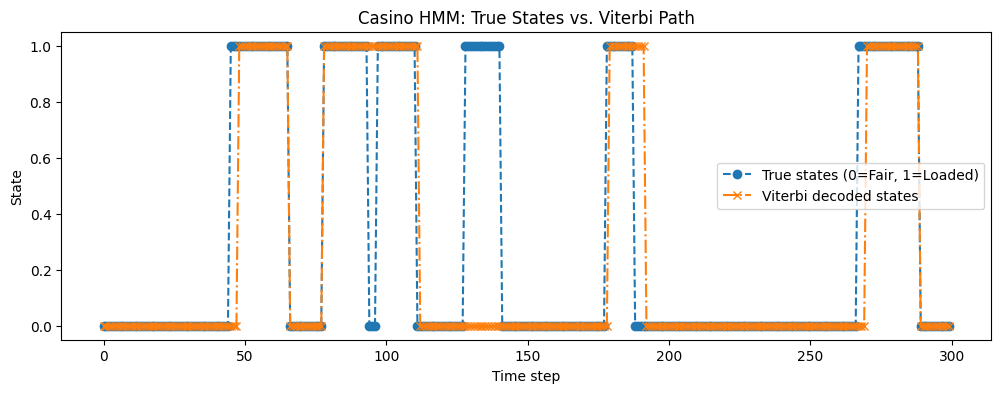

In [89]:
plt.figure(figsize=(12,4))
plt.plot(true_states, label="True states (0=Fair, 1=Loaded)", marker="o", linestyle="--")
plt.plot(sigma_v, label="Viterbi decoded states", marker="x", linestyle="-.")
plt.xlabel("Time step")
plt.ylabel("State")
plt.title("Casino HMM: True States vs. Viterbi Path")
plt.legend()
plt.show()

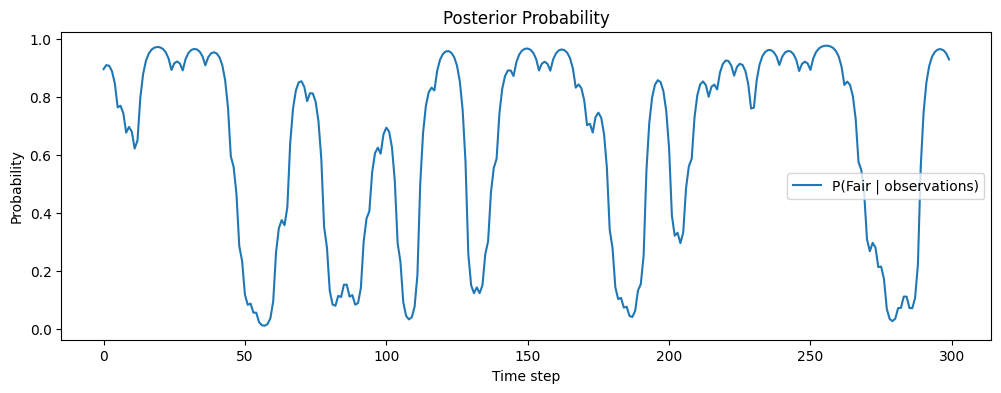

In [90]:
plt.figure(figsize=(12,4))
plt.plot(p_fair, label="P(Fair | observations)")
#plt.plot(p_loaded, label="P(Loaded | observations)")
plt.xlabel("Time step")
plt.ylabel("Probability")
plt.title("Posterior Probability")
plt.legend()
plt.show()

In [73]:
A_est, B_est, pi_est = baum_welch(observations, n_iter=50)
print("Transition Matrix A:")
print(A_est)
print("\nEmission Matrix B:")
print(B_est)

Transition Matrix A:
[[0.65925013 0.34074987]
 [0.93363554 0.06636446]]

Emission Matrix B:
[[0.14758628 0.05783966 0.12519523 0.13579839 0.18750324 0.34607719]
 [0.09472782 0.37490133 0.26663412 0.08957052 0.0113328  0.16283341]]


# Тесты

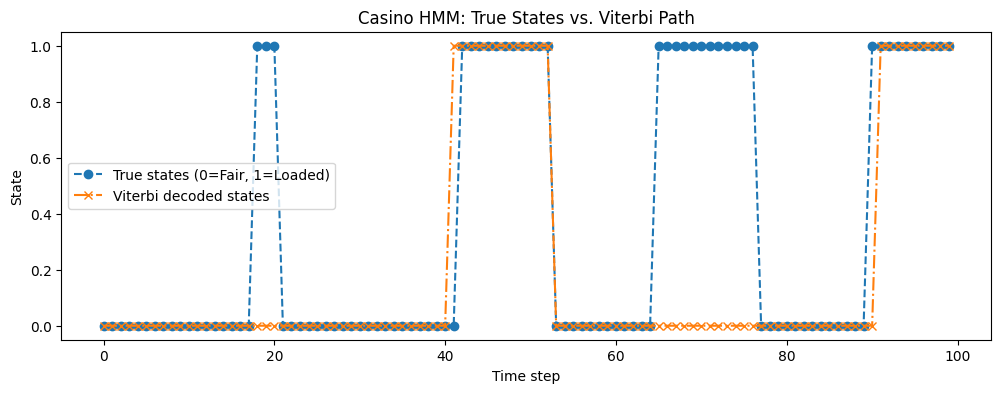

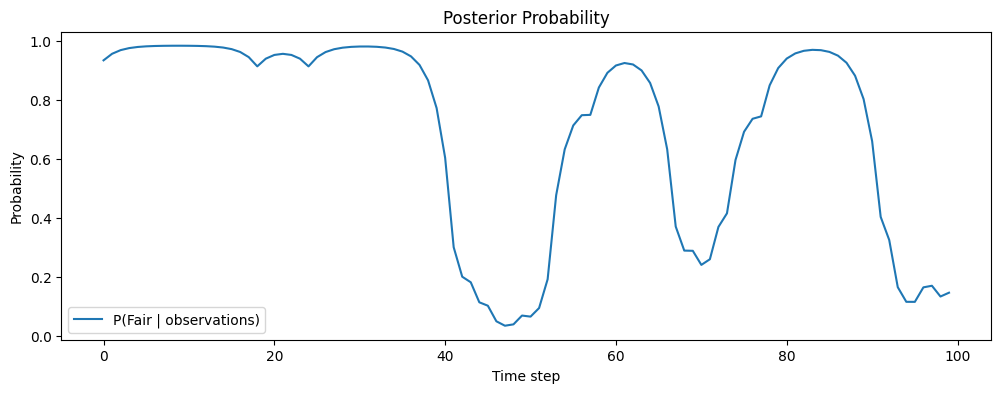

Transition Matrix A:
[[0.24815363 0.75184637]
 [0.80993687 0.19006313]]

Emission Matrix B:
[[0.27615418 0.05908467 0.0048704  0.08836334 0.26027576 0.31125165]
 [0.03657218 0.28786091 0.36609632 0.07111294 0.07407112 0.16428653]]


In [93]:
with open("casino_test_100.txt", "r") as f:
    content = f.read().strip()
parts = content.split()
observations_str = parts[0]
states_str = parts[1]
observations = np.array([int(ch)-1 for ch in observations_str if ch.isdigit()])
true_states = np.array([0 if ch=='F' else 1 for ch in states_str if ch in ['F','L']])

L = len(observations)

sigma_v = viterbi(observations, M, E, pi)

alpha, log_prob_forward, scale = forward(observations, M, E, pi)
beta = backward(observations, M, E, scale)

gamma = posterior_decoding(alpha, beta)
p_fair = gamma[:, 0]

plt.figure(figsize=(12,4))
plt.plot(true_states, label="True states (0=Fair, 1=Loaded)", marker="o", linestyle="--")
plt.plot(sigma_v, label="Viterbi decoded states", marker="x", linestyle="-.")
plt.xlabel("Time step")
plt.ylabel("State")
plt.title("Casino HMM: True States vs. Viterbi Path")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(p_fair, label="P(Fair | observations)")
#plt.plot(p_loaded, label="P(Loaded | observations)")
plt.xlabel("Time step")
plt.ylabel("Probability")
plt.title("Posterior Probability")
plt.legend()
plt.show()

A_est, B_est, pi_est = baum_welch(observations, n_iter=10)
print("Transition Matrix A:")
print(A_est)
print("\nEmission Matrix B:")
print(B_est)

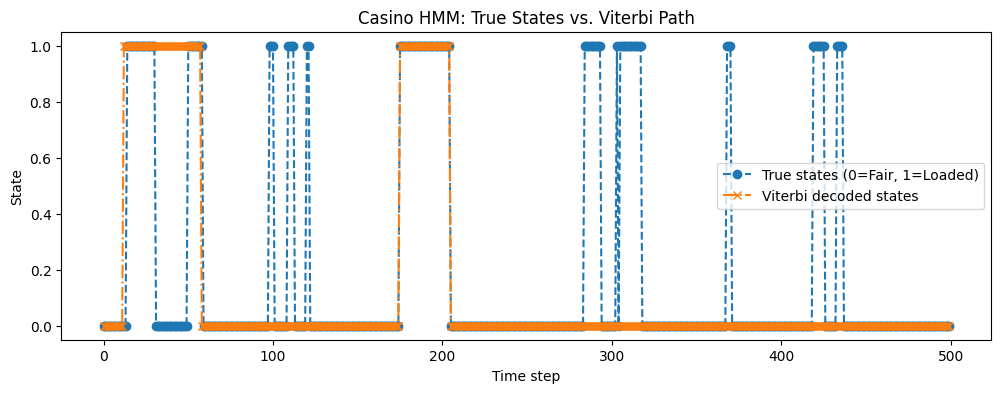

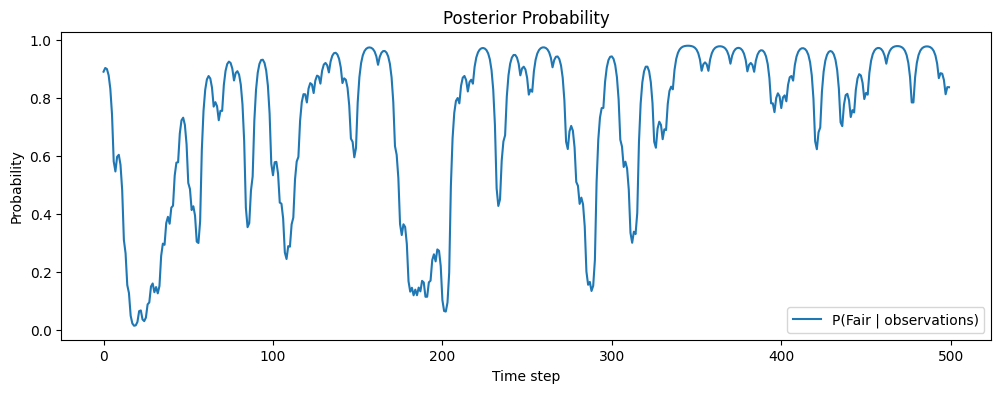

Transition Matrix A:
[[0.89218027 0.10781973]
 [0.32600166 0.67399834]]

Emission Matrix B:
[[0.09877164 0.09515231 0.17413262 0.20226594 0.12544908 0.30422841]
 [0.3468132  0.23632343 0.01965396 0.10396246 0.22490706 0.0683399 ]]


In [92]:
with open("casino_test_500.txt", "r") as f:
    content = f.read().strip()
parts = content.split()
observations_str = parts[0]
states_str = parts[1]
observations = np.array([int(ch)-1 for ch in observations_str if ch.isdigit()])
true_states = np.array([0 if ch=='F' else 1 for ch in states_str if ch in ['F','L']])

L = len(observations)

sigma_v = viterbi(observations, M, E, pi)

alpha, log_prob_forward, scale = forward(observations, M, E, pi)
beta = backward(observations, M, E, scale)

gamma = posterior_decoding(alpha, beta)
p_fair = gamma[:, 0]

plt.figure(figsize=(12,4))
plt.plot(true_states, label="True states (0=Fair, 1=Loaded)", marker="o", linestyle="--")
plt.plot(sigma_v, label="Viterbi decoded states", marker="x", linestyle="-.")
plt.xlabel("Time step")
plt.ylabel("State")
plt.title("Casino HMM: True States vs. Viterbi Path")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(p_fair, label="P(Fair | observations)")
#plt.plot(p_loaded, label="P(Loaded | observations)")
plt.xlabel("Time step")
plt.ylabel("Probability")
plt.title("Posterior Probability")
plt.legend()
plt.show()

A_est, B_est, pi_est = baum_welch(observations, n_iter=10)
print("Transition Matrix A:")
print(A_est)
print("\nEmission Matrix B:")
print(B_est)

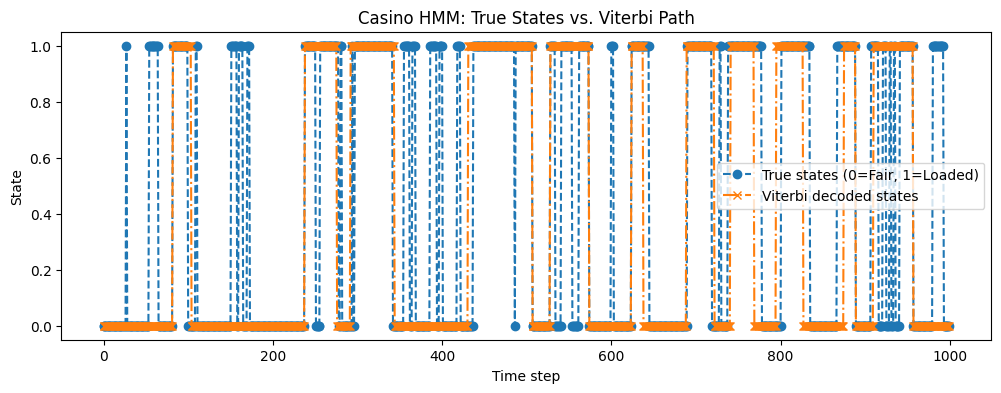

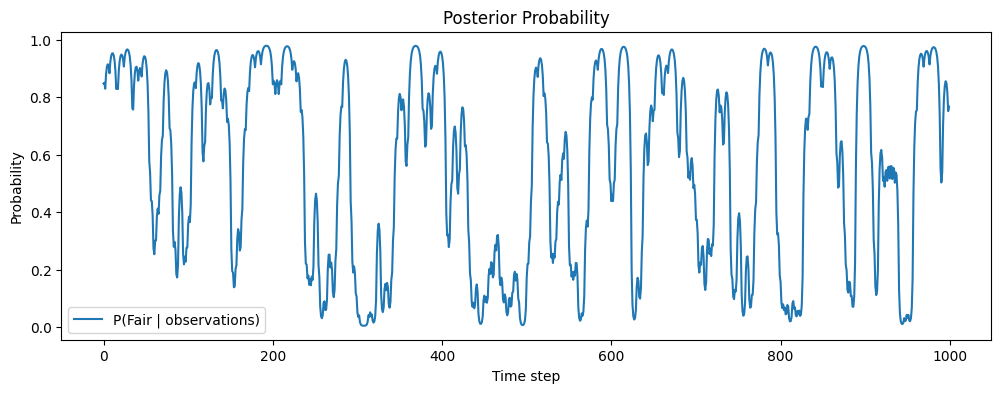

Estimated Transition Matrix A:
[[0.93895938 0.06104062]
 [0.13581667 0.86418333]]

Estimated Emission Matrix B:
[[0.1036828  0.13490446 0.12672712 0.11962887 0.07678485 0.4382719 ]
 [0.24088585 0.16115225 0.12761187 0.17595046 0.19420352 0.10019604]]


In [91]:
with open("casino_test_1000.txt", "r") as f:
    content = f.read().strip()
parts = content.split()
observations_str = parts[0]
states_str = parts[1]
observations = np.array([int(ch)-1 for ch in observations_str if ch.isdigit()])
true_states = np.array([0 if ch=='F' else 1 for ch in states_str if ch in ['F','L']])

L = len(observations)

sigma_v = viterbi(observations, M, E, pi)

alpha, log_prob_forward, scale = forward(observations, M, E, pi)
beta = backward(observations, M, E, scale)

gamma = posterior_decoding(alpha, beta)
p_fair = gamma[:, 0]

plt.figure(figsize=(12,4))
plt.plot(true_states, label="True states (0=Fair, 1=Loaded)", marker="o", linestyle="--")
plt.plot(sigma_v, label="Viterbi decoded states", marker="x", linestyle="-.")
plt.xlabel("Time step")
plt.ylabel("State")
plt.title("Casino HMM: True States vs. Viterbi Path")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(p_fair, label="P(Fair | observations)")
#plt.plot(p_loaded, label="P(Loaded | observations)")
plt.xlabel("Time step")
plt.ylabel("Probability")
plt.title("Posterior Probability")
plt.legend()
plt.show()

A_est, B_est, pi_est = baum_welch(observations, n_iter=10)
print("Estimated Transition Matrix A:")
print(A_est)
print("\nEstimated Emission Matrix B:")
print(B_est)